In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from collections import OrderedDict

data_types = OrderedDict([
    ("age", "int"),
    ("workclass", "category"),
    ("final_weight", "int"),  # originally it was called fnlwgt
    ("education", "category"),
    ("education_num", "int"),
    ("marital_status", "category"),
    ("occupation", "category"),
    ("relationship", "category"),
    ("race", "category"),
    ("sex", "category"),
    ("capital_gain", "float"),  # required because of NaN values
    ("capital_loss", "int"),
    ("hours_per_week", "int"),
    ("native_country", "category"),
    ("income_class", "category"),
])
target_column = "income_class"

In [3]:
def read_dataset(path):
    return pd.read_csv(
        path,
        names=data_types,
        index_col=None,

        comment='|',  # test dataset has comment in it
        skipinitialspace=True,  # Skip spaces after delimiter
        na_values={
            'capital_gain': 99999,
            'workclass': '?',
            'native_country': '?',
            'occupation': '?',
        },
        dtype=data_types,
    )

def clean_dataset(data):
    # Test dataset has dot at the end, we remove it in order
    # to unify names between training and test datasets.
    data['income_class'] = data.income_class.str.rstrip('.').astype('category')
    
    # Remove final weight column since there is no use
    # for it during the classification.
    data = data.drop('final_weight', axis=1)
    
    # Duplicates might create biases during the analysis and
    # during prediction stage they might give over-optimistic
    # (or pessimistic) results.
    data = data.drop_duplicates()
    
    # Binarize target variable (>50K == 1 and <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)

    return data

def deduplicate(train_data, test_data):
    train_data['is_test'] = 0
    test_data['is_test'] = 1

    data = pd.concat([train_data, test_data])
    # For some reason concatenation converts this column to object
    data['native_country'] = data.native_country.astype('category')
    data = data.drop_duplicates()
    
    train_data = data[data.is_test == 0].drop('is_test', axis=1)
    test_data = data[data.is_test == 1].drop('is_test', axis=1)
    
    return train_data, test_data

In [4]:
train_data = clean_dataset(read_dataset("adult.data"))
test_data = clean_dataset(read_dataset("adult.test"))

In [5]:
train_data, test_data = deduplicate(train_data, test_data)
print("Percent of the positive classes in the training data: {:.2%}".format(np.mean(train_data.income_class)))

Percent of the positive classes in the training data: 24.78%


In [6]:
train_data.head(5)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_class
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0,40,Cuba,0


In [7]:
def get_categorical_columns(data, cat_columns=None, fillna=True):
    if cat_columns is None:
        cat_data = data.select_dtypes('category')
    else:
        cat_data = data[cat_columns]

    if fillna:
        for colname, series in cat_data.iteritems():
            if 'Other' not in series.cat.categories:
                series = series.cat.add_categories(['Other'])

            cat_data[colname] = series.fillna('Other')
            
    return cat_data

def features_with_one_hot_encoded_categories(data, cat_columns=None, fillna=True):
    cat_data = get_categorical_columns(data, cat_columns, fillna)
    one_hot_data = pd.get_dummies(cat_data)
    df = pd.concat([data, one_hot_data], axis=1)

    features = [
        'age',
        'education_num',
        'hours_per_week',
        'capital_gain',
        'capital_loss',
    ] + one_hot_data.columns.tolist()

    X = df[features].fillna(0).values.astype(float)
    y = df[target_column].values
    
    return one_hot_data, y

In [8]:
X = train_data
X = pd.get_dummies(X) #в датасете есть данные типа категория -> переходим в числа
X = X.dropna()
y = X[target_column]
X = X.drop(target_column, axis=1)

In [9]:
from sklearn.metrics import mean_squared_error as mse

class RegressionTree():
    def __init__(self, max_depth=3, n_epoch=10, min_size=8):
        self.max_depth = max_depth # максимальная глубина
        self.min_size = min_size # минимальный размер поддерева
        self.value = 0 # значение в поддереве (среднее по всем листьям)
        self.feature_idx = -1 # номер лучшего признака
        self.feature_threshold = 0 # значение лучшего признака
        self.left = None # левый потомок
        self.right = None # правый потомок
        
    def fit(self, X, y):
        self.value = y.mean()
        base_error = ((y - self.value) ** 2).sum()
        error = base_error
        flag = 0
        
        prev_error_left = base_error
        prev_error_right = 0
        
        if self.max_depth <= 1:
            return
    
        dim_shape = X.shape[1]
        
        left_value = 0
        right_value = 0
        
        for feat in range(dim_shape):
            idxs = np.argsort(X[:, feat])
            
            N = X.shape[0]
            N1, N2 = N, 0
            thres = 1
            
            while thres < N - 1:
                N1 -= 1
                N2 += 1
                
                idx = idxs[thres]
                x = X[idx, feat]
                
                if thres < N - 1 and x == X[idxs[thres + 1], feat]:
                    thres += 1
                    continue
                    
                target_right = y[idxs][:thres]
                target_left = y[idxs][thres:]
                mean_right = y[idxs][:thres].mean(), 
                mean_left = y[idxs][thres:].mean()
                left_shape = target_left.shape[0]
                right_shape = target_right.shape[0]
                mean_left_array = [mean_left for _ in range(left_shape)]
                mean_right_array = [mean_right for _ in range(right_shape)]
                
                prev_error_left = N1/N * mse(target_left, mean_left_array) 
                prev_error_right = N2/N * mse(target_right, mean_right_array)
                
                if (prev_error_left + prev_error_right < error):
                        if (min(N1,N2) > self.min_size):
                            self.feature_idx = feat
                            self.feature_threshold = x
                            left_value = mean_left
                            right_value = mean_right

                            flag = 1
                            error = prev_error_left + prev_error_right
                                     
                thres += 1
                
        if self.feature_idx == -1:
            return
        
        self.left = RegressionTree(self.max_depth - 1)
        self.left.value = left_value
        self.right = RegressionTree(self.max_depth - 1)
        self.right.value = right_value
        
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
        
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])
        
    def __predict(self, x):
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y

In [10]:
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

(28938, 104) (28938,)


In [11]:
from sklearn.model_selection import KFold

def get_metrics(X,y,n_folds=2, model=None):

    kf = KFold(n_splits=n_folds, shuffle=True)
    kf.get_n_splits(X)

    er_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train,y_train)
        predict = model.predict(X_test)
        er_list.append(mse(y_test, predict))
    
    return er_list

In [13]:
import matplotlib.pyplot as plt

er_sklearn_tree = get_metrics(X,y,30,DecisionTreeRegressor(max_depth=4, min_samples_leaf=10))
er_custom_tree = get_metrics(X,y,30,RegressionTree(4, min_size=10))

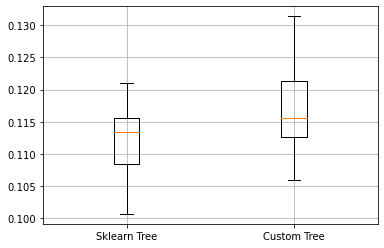

In [14]:
%matplotlib inline
data = [er_sklearn_tree, er_custom_tree]
fig7, ax7 = plt.subplots()
ax7.set_title('')
ax7.boxplot(data, labels=['Sklearn Tree', 'Custom Tree'])
plt.grid()
plt.show()

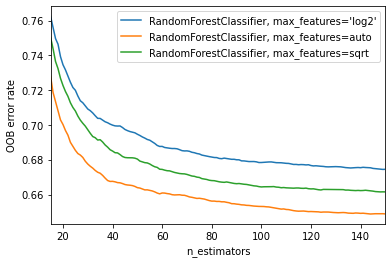

In [17]:
from sklearn.ensemble import RandomForestRegressor
from collections import OrderedDict
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

ensemble_clfs = [
    ("RandomForestClassifier, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True, random_state=42, n_jobs=-1)),
    ("RandomForestClassifier, max_features=auto",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True, random_state=42, n_jobs=-1)),
    ("RandomForestClassifier, max_features=sqrt",
        RandomForestRegressor(warm_start=True, max_features='sqrt',
                               oob_score=True, random_state=42, n_jobs=-1))]


error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 15
max_estimators = 150

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()